In [1]:
using Plots
using LinearAlgebra
using Revise
using Optim
#using FFTW
using Nevanlinna
using Zygote
using LaTeXStrings
using MultiFloats
using SparseIR

┌ Info: Precompiling Nevanlinna [0b21cfa8-e591-48a4-a07b-a9d20be7c264]
└ @ Base loading.jl:1423


In [2]:
# Set work data Type
#T = Float64x2
T = BigFloat

BigFloat

In [3]:
beta = 10
wmax = 10
IR_basis_set = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) 
;

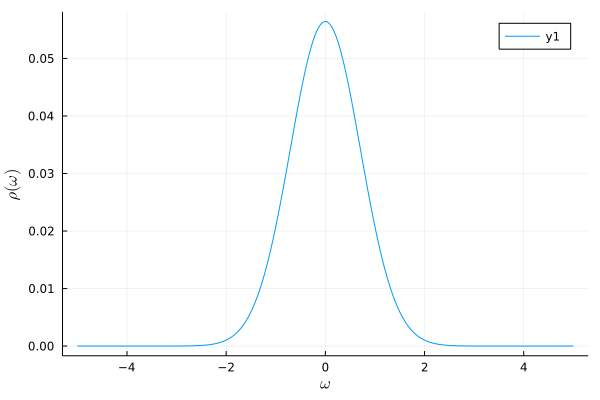

In [4]:
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)
lorentzian(x, mu, gamma) = gamma/(pi*(gamma^2+(x-mu)^2))

#rho(omega) = gaussian(omega, 0.0, 0.15)  
#rho(omega) = (0.1*gaussian(omega, 1, 1) - 0.1*gaussian(omega, -1, 1))/tanh(0.5*beta*omega)
rho(omega) = 0.1*gaussian(omega, 0, 1)


omegas = LinRange(-5, 5, 1000)
#plot(omegas, rho.(omegas).*tanh.(0.5*beta*omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))
plot(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [5]:
rhol_f = [overlap(IR_basis_set.basis_f.v[l], rho) for l in 1:length(IR_basis_set.basis_f)]
rhol_b = [overlap(IR_basis_set.basis_b.v[l], rho) for l in 1:length(IR_basis_set.basis_b)]
rhol_f == rhol_b

true

In [6]:
gl_f = - IR_basis_set.basis_f.s .* rhol_f
gl_b = - IR_basis_set.basis_b.s .* rhol_b
gl_f == gl_b

true

In [7]:
rhol = [overlap(IR_basis_set.basis_b.v[l], rho) for l in 1:length(IR_basis_set.basis_b)]
gl = - IR_basis_set.basis_b.s .* rhol
;

In [8]:
gw = evaluate(IR_basis_set.smpl_wn_f, gl)
hnw = length(IR_basis_set.smpl_wn_f.sampling_points)÷2

20

In [9]:
sum = -dot(IR_basis_set.basis_f.u(beta), gl) - dot(IR_basis_set.basis_f.u(0), gl)

0.09999999999999984

In [10]:
setprecision(512)

512

In [11]:
test_gw   = Array{Complex{T}}(undef, hnw) 
test_smpl = Array{Complex{T}}(undef, hnw) 
;

In [12]:
for i in 1:hnw
    test_smpl[i]= SparseIR.valueim(IR_basis_set.smpl_wn_f.sampling_points[hnw+i], SparseIR.β(IR_basis_set))
    test_gw[i]  = gw[hnw+i]
end

In [13]:
N_real    =  1000
omega_max =  10.0
eta       =  0.001
H_max     =  50
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-5
iter_tol  = 1000
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, test_smpl, test_gw)
println("N_imag $(N_imag)")

N_imag is setted as 14
N_imag 14


In [14]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, test_smpl, test_gw, N_real, omega_max, eta, sum, H_max, iter_tol, lambda, true)
;

Pick matrix is positive semi-definite.
H=1
Iter     Function value   Gradient norm 
     0     4.269635e-04     1.867166e-03
 * time: 0.020348787307739258
     1     1.702750e-04     9.929614e-04
 * time: 1.7443079948425293
     2     1.496441e-04     1.210738e-03
 * time: 2.0818629264831543
     3     1.415810e-04     1.319417e-03
 * time: 2.518789768218994
     4     2.444193e-05     9.173276e-05
 * time: 2.9785878658294678
     5     2.336714e-05     8.483023e-06
 * time: 3.319450855255127
     6     2.335024e-05     1.000051e-06
 * time: 3.6702818870544434
     7     2.335016e-05     8.734565e-09
 * time: 4.022063970565796
max_theta=0.26936103559665388830054981939073793362260905902302812798660231310456261048313347047055657213267102592387983232051203240161193527909724581528817149684706508
hardy optimization was success.
 40.728564 seconds (124.76 M allocations: 7.118 GiB, 7.53% gc time, 91.50% compilation time)


In [15]:
@time Nevanlinna.solve!(sol)
;

H=1
Iter     Function value   Gradient norm 
     0     2.335016e-05     8.734565e-09
 * time: 0.00018787384033203125
max_theta=0.26936103559665388830054981939073793362260905902302812798660231310456261048313347047055657213267102592387983232051203240161193527909724581528817149684706508
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     2.335016e-05     2.762866e-04
 * time: 0.00018906593322753906
     1     1.887437e-05     2.026489e-04
 * time: 0.5870869159698486
     2     1.150834e-05     1.406497e-04
 * time: 1.2732820510864258
     3     1.054045e-05     1.048525e-04
 * time: 1.649090051651001
     4     9.918655e-06     1.063032e-04
 * time: 2.2099030017852783
     5     6.626410e-06     1.759819e-05
 * time: 2.7088849544525146
     6     6.604470e-06     1.326611e-05
 * time: 3.0391011238098145
     7     6.579177e-06     1.881104e-05
 * time: 3.760366916656494
     8     4.628168e-06     4.555384e-05
 * time: 4.330796957015991
     9     3.93

    19     1.299159e-07     4.885764e-08
 * time: 13.533440113067627
    20     1.299158e-07     4.783818e-08
 * time: 13.991971015930176
    21     1.299157e-07     4.941043e-08
 * time: 14.78621506690979
    22     1.299071e-07     5.628588e-08
 * time: 15.584912061691284
    23     1.294785e-07     2.922969e-07
 * time: 16.361631155014038
    24     1.271852e-07     2.726613e-07
 * time: 17.007665157318115
    25     1.268482e-07     7.376765e-08
 * time: 17.481945991516113
    26     1.268464e-07     7.093475e-08
 * time: 17.785017013549805
    27     1.268464e-07     7.168934e-08
 * time: 18.2642240524292
    28     1.268461e-07     6.854754e-08
 * time: 18.919767141342163
    29     1.268367e-07     6.949593e-08
 * time: 19.70587706565857
    30     1.266142e-07     2.125145e-07
 * time: 20.3511860370636
    31     1.243786e-07     4.655932e-07
 * time: 21.006091117858887
    32     1.228736e-07     4.388595e-08
 * time: 21.48122811317444
    33     1.228521e-07     1.704393e-08


   101     1.207521e-07     1.865851e-08
 * time: 52.01803398132324
   102     1.207520e-07     1.877446e-08
 * time: 52.38959789276123
   103     1.207520e-07     1.837822e-08
 * time: 52.89021587371826
   104     1.207520e-07     1.826984e-08
 * time: 53.230509996414185
   105     1.207520e-07     1.858130e-08
 * time: 53.73483490943909
   106     1.207520e-07     1.869049e-08
 * time: 54.05674600601196
   107     1.207520e-07     1.837606e-08
 * time: 54.55971002578735
   108     1.207520e-07     1.830541e-08
 * time: 54.89677691459656
   109     1.207520e-07     1.866521e-08
 * time: 55.40198993682861
   110     1.207520e-07     1.872005e-08
 * time: 55.745131969451904
   111     1.207519e-07     1.823856e-08
 * time: 56.24496793746948
   112     1.207519e-07     1.819643e-08
 * time: 56.58704209327698
   113     1.207519e-07     1.886382e-08
 * time: 57.08137798309326
   114     1.207519e-07     1.896799e-08
 * time: 57.42021608352661
   115     1.207519e-07     1.803519e-08
 * ti

    60     1.165421e-07     5.250484e-08
 * time: 36.191251039505005
    61     1.165420e-07     5.249264e-08
 * time: 36.73587703704834
    62     1.165418e-07     5.236224e-08
 * time: 37.319719076156616
    63     1.165416e-07     5.253694e-08
 * time: 37.86087608337402
    64     1.165413e-07     5.234089e-08
 * time: 38.398289918899536
    65     1.165408e-07     5.250116e-08
 * time: 38.93465805053711
    66     1.165402e-07     5.213818e-08
 * time: 39.472387075424194
    67     1.165393e-07     5.264102e-08
 * time: 40.04036808013916
    68     1.165380e-07     5.184267e-08
 * time: 40.58437514305115
    69     1.165360e-07     6.044944e-08
 * time: 41.12180304527283
    70     1.165334e-07     5.145839e-08
 * time: 41.66503405570984
    71     1.165294e-07     7.266711e-08
 * time: 42.22574591636658
    72     1.165239e-07     6.963838e-08
 * time: 42.76373600959778
    73     1.165156e-07     9.138375e-08
 * time: 43.30415105819702
    74     1.165042e-07     9.936654e-08
 * 

    41     1.105375e-07     6.590348e-08
 * time: 27.473305225372314
    42     1.105327e-07     6.697438e-08
 * time: 28.062941074371338
    43     1.105316e-07     6.320936e-08
 * time: 28.63978600502014
    44     1.105315e-07     6.150601e-08
 * time: 29.04552912712097
    45     1.105315e-07     6.082588e-08
 * time: 29.6490261554718
    46     1.105314e-07     6.058815e-08
 * time: 30.259871006011963
    47     1.105314e-07     6.006214e-08
 * time: 30.851327180862427
    48     1.105313e-07     5.961708e-08
 * time: 31.444945096969604
    49     1.105310e-07     5.779468e-08
 * time: 32.054755210876465
    50     1.105305e-07     5.436865e-08
 * time: 32.64891004562378
    51     1.105287e-07     4.380079e-08
 * time: 33.250434160232544
    52     1.105239e-07     4.744880e-08
 * time: 33.8545241355896
    53     1.105088e-07     4.957642e-08
 * time: 34.44311499595642
    54     1.105011e-07     4.917279e-08
 * time: 35.043440103530884
    55     1.105004e-07     2.810626e-08
 

   162     1.104974e-07     1.466247e-08
 * time: 81.25517416000366
   163     1.104974e-07     1.523426e-08
 * time: 81.66534519195557
   164     1.104974e-07     1.464945e-08
 * time: 82.04858016967773
   165     1.104974e-07     1.521961e-08
 * time: 82.44704413414001
   166     1.104974e-07     1.463603e-08
 * time: 82.846755027771
   167     1.104974e-07     1.520488e-08
 * time: 83.25171899795532
   168     1.104974e-07     1.462230e-08
 * time: 83.6716480255127
   169     1.104974e-07     1.518992e-08
 * time: 84.0783200263977
   170     1.104973e-07     1.460840e-08
 * time: 84.47665619850159
   171     1.104973e-07     1.517468e-08
 * time: 84.88114619255066
   172     1.104973e-07     1.459441e-08
 * time: 85.26338315010071
   173     1.104973e-07     1.515920e-08
 * time: 85.67449522018433
   174     1.104973e-07     1.458034e-08
 * time: 86.07251715660095
   175     1.104973e-07     1.514365e-08
 * time: 86.46886920928955
   176     1.104973e-07     1.456610e-08
 * time: 86

   282     1.104971e-07     1.367390e-08
 * time: 129.31237721443176
   283     1.104971e-07     1.424063e-08
 * time: 129.69405722618103
   284     1.104971e-07     1.365469e-08
 * time: 130.10502409934998
   285     1.104971e-07     1.422171e-08
 * time: 130.50144720077515
   286     1.104971e-07     1.363541e-08
 * time: 130.8986620903015
   287     1.104971e-07     1.420270e-08
 * time: 131.30650520324707
   288     1.104971e-07     1.361607e-08
 * time: 131.73368000984192
   289     1.104971e-07     1.418359e-08
 * time: 132.1448130607605
   290     1.104971e-07     1.359665e-08
 * time: 132.54641222953796
   291     1.104971e-07     1.416440e-08
 * time: 132.95317220687866
   292     1.104971e-07     1.357716e-08
 * time: 133.33063220977783
   293     1.104971e-07     1.414512e-08
 * time: 133.7247850894928
   294     1.104971e-07     1.355758e-08
 * time: 134.12435913085938
   295     1.104971e-07     1.412575e-08
 * time: 134.53293919563293
   296     1.104971e-07     1.353791e

   402     1.104969e-07     1.237810e-08
 * time: 177.387460231781
   403     1.104969e-07     1.296300e-08
 * time: 177.7848310470581
   404     1.104969e-07     1.235415e-08
 * time: 178.18537020683289
   405     1.104969e-07     1.293939e-08
 * time: 178.59375500679016
   406     1.104969e-07     1.233013e-08
 * time: 179.00003600120544
   407     1.104969e-07     1.291571e-08
 * time: 179.39612913131714
   408     1.104969e-07     1.230605e-08
 * time: 179.79560112953186
   409     1.104969e-07     1.289196e-08
 * time: 180.20884013175964
   410     1.104969e-07     1.228190e-08
 * time: 180.59587216377258
   411     1.104969e-07     1.286814e-08
 * time: 181.0148000717163
   412     1.104969e-07     1.225767e-08
 * time: 181.42040300369263
   413     1.104969e-07     1.284425e-08
 * time: 181.83001017570496
   414     1.104969e-07     1.223338e-08
 * time: 182.2354700565338
   415     1.104969e-07     1.282029e-08
 * time: 182.63909006118774
   416     1.104969e-07     1.220902e-0

   522     1.104966e-07     1.124581e-08
 * time: 225.52887201309204
   523     1.104966e-07     1.143342e-08
 * time: 225.9354841709137
   524     1.104966e-07     1.130881e-08
 * time: 226.33681511878967
   525     1.104966e-07     1.140623e-08
 * time: 226.73803210258484
   526     1.104966e-07     1.137182e-08
 * time: 227.14605617523193
   527     1.104966e-07     1.137900e-08
 * time: 227.52828001976013
   528     1.104966e-07     1.143484e-08
 * time: 227.93561220169067
   529     1.104966e-07     1.135172e-08
 * time: 228.3336901664734
   530     1.104966e-07     1.149786e-08
 * time: 228.7375090122223
   531     1.104966e-07     1.139653e-08
 * time: 229.14690113067627
   532     1.104966e-07     1.156089e-08
 * time: 229.55021619796753
   533     1.104966e-07     1.145882e-08
 * time: 229.94865608215332
   534     1.104966e-07     1.162393e-08
 * time: 230.35070204734802
   535     1.104966e-07     1.152110e-08
 * time: 230.73368000984192
   536     1.104966e-07     1.168698e

   642     1.104963e-07     1.501846e-08
 * time: 273.51690316200256
   643     1.104963e-07     1.487664e-08
 * time: 273.8984100818634
   644     1.104963e-07     1.508069e-08
 * time: 274.30695104599
   645     1.104963e-07     1.493816e-08
 * time: 274.7058410644531
   646     1.104963e-07     1.514287e-08
 * time: 275.1083462238312
   647     1.104963e-07     1.499964e-08
 * time: 275.5113101005554
   648     1.104963e-07     1.520502e-08
 * time: 275.92791414260864
   649     1.104963e-07     1.506107e-08
 * time: 276.3192811012268
   650     1.104963e-07     1.526712e-08
 * time: 276.7194390296936
   651     1.104963e-07     1.512246e-08
 * time: 277.12965512275696
   652     1.104963e-07     1.532918e-08
 * time: 277.51199102401733
   653     1.104963e-07     1.518380e-08
 * time: 277.90985012054443
   654     1.104963e-07     1.539119e-08
 * time: 278.3079340457916
   655     1.104963e-07     1.524510e-08
 * time: 278.70814514160156
   656     1.104963e-07     1.545316e-08
 * 

   762     1.104959e-07     1.863792e-08
 * time: 321.52647614479065
   763     1.104959e-07     1.845299e-08
 * time: 321.9321081638336
   764     1.104959e-07     1.869546e-08
 * time: 322.31312322616577
   765     1.104959e-07     1.850981e-08
 * time: 322.72491812705994
   766     1.104959e-07     1.875289e-08
 * time: 323.1232662200928
   767     1.104959e-07     1.856652e-08
 * time: 323.52397203445435
   768     1.104959e-07     1.881020e-08
 * time: 323.95296907424927
   769     1.104959e-07     1.862310e-08
 * time: 324.35331416130066
   770     1.104959e-07     1.886738e-08
 * time: 324.752090215683
   771     1.104959e-07     1.867955e-08
 * time: 325.1582450866699
   772     1.104959e-07     1.892444e-08
 * time: 325.5397961139679
   773     1.104959e-07     1.873588e-08
 * time: 325.9522030353546
   774     1.104959e-07     1.898137e-08
 * time: 326.3488450050354
   775     1.104959e-07     1.879209e-08
 * time: 326.7501380443573
   776     1.104959e-07     1.903817e-08
 *

   882     1.104955e-07     2.181981e-08
 * time: 369.50628209114075
   883     1.104955e-07     2.159193e-08
 * time: 369.90913105010986
   884     1.104955e-07     2.186709e-08
 * time: 370.3091690540314
   885     1.104955e-07     2.163852e-08
 * time: 370.7177791595459
   886     1.104955e-07     2.191414e-08
 * time: 371.1010410785675
   887     1.104955e-07     2.168488e-08
 * time: 371.4997751712799
   888     1.104955e-07     2.196096e-08
 * time: 371.9008641242981
   889     1.104955e-07     2.173101e-08
 * time: 372.32520723342896
   890     1.104955e-07     2.200755e-08
 * time: 372.7367250919342
   891     1.104955e-07     2.177692e-08
 * time: 373.1422221660614
   892     1.104955e-07     2.205390e-08
 * time: 373.5420560836792
   893     1.104955e-07     2.182259e-08
 * time: 373.9457621574402
   894     1.104955e-07     2.210002e-08
 * time: 374.32888317108154
   895     1.104954e-07     2.186803e-08
 * time: 374.740061044693
   896     1.104954e-07     2.214591e-08
 * t

In [16]:
#ab_coeff  = zeros(Complex{T}, 2*H) 

imaginary = Nevanlinna.ImagDomainData(test_smpl, test_gw, N_imag)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, sum, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation!(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)
;

Pick matrix is positive semi-definite.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.


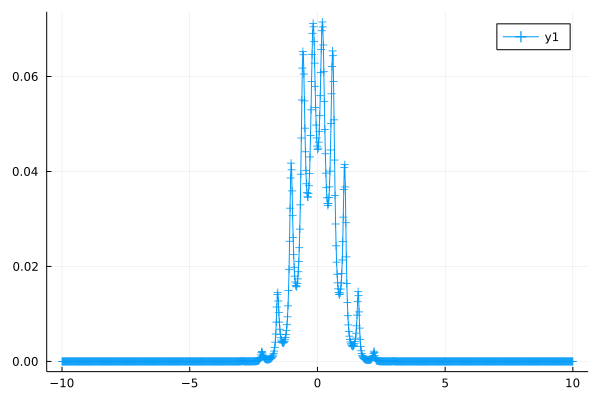

In [21]:
#plot(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*beta*real.(raw_reals.freq)),marker=:+)
plot(real.(raw_reals.freq), imag.(raw_reals.val/pi),marker=:+)

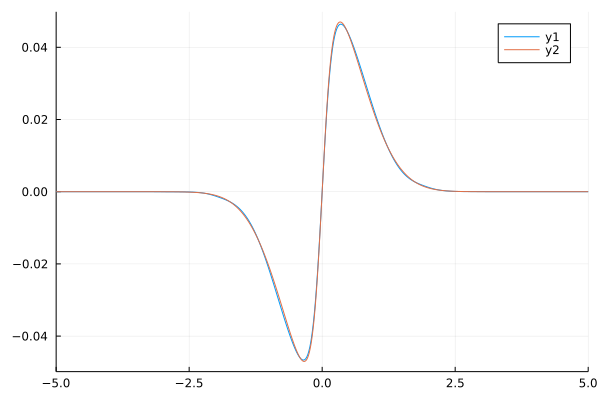

In [18]:
plot(xlim = [-5,5])
#plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*beta*real.(raw_reals.freq)))
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val)).*tanh.(0.5*beta*real.(sol.reals.freq))/pi)
plot!(omegas, rho.(omegas).*tanh.(0.5*beta*omegas))

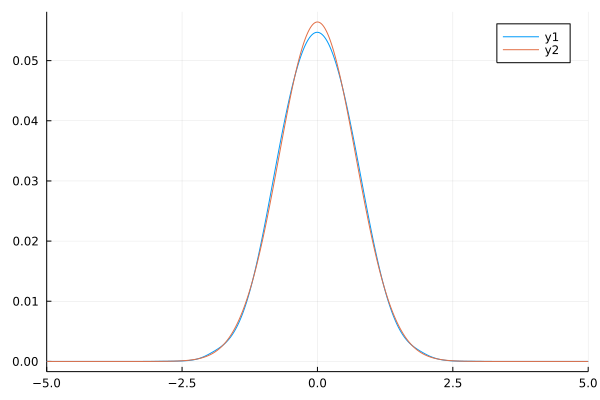

In [19]:
plot(xlim = [-5,5])
#plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi))
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val))/pi)
plot!(omegas, rho.(omegas))